## Setup

In [79]:
import requests
from time import sleep
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.precision", 8)

In [37]:
base = "https://app.xcalibra.com/api/public/v1/price-history/SFX_BTC"
payload = {'interval':'minute','limit':1000}

r = requests.get(base,params=payload).json()
data = []
pbar = tqdm()
while(r[0]['open'] != 0):
    to_timestamp = r[0]['timestamp']
    payload = {'interval':'minute', 'to_timestamp': to_timestamp, 'limit':1000}
    r = requests.get(base, params=payload).json()
    data.append(r)
    pbar.update()

cleaned_data = [item for sublist in data for item in sublist]
df = pd.DataFrame(cleaned_data)
df.fillna(value=0, inplace=True)
df.iloc[:] = df.iloc[::-1].values
df[['volume','quantity']] = df[['volume','quantity']].apply(pd.to_numeric)
df.to_csv("dataset.csv")

In [67]:
df.describe()

,open,high,low,close,count,volume,quantity
count,504000.00000000,504000.00000000,504000.00000000,504000.00000000,504000.00000000,504000.00000000,504000.00000000
mean,0.00000302,0.00000302,0.00000302,0.00000302,0.06485714,0.00009251,47.01453466
std,0.00001481,0.00001481,0.00001481,0.00001481,0.45041901,0.00219194,1239.89825631
min,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,0.00000093,0.00000093,0.00000093,0.00000093,0.00000000,0.00000000,0.00000000
50%,0.00000134,0.00000134,0.00000134,0.00000134,0.00000000,0.00000000,0.00000000
75%,0.00000233,0.00000233,0.00000233,0.00000233,0.00000000,0.00000000,0.00000000
max,0.00025000,0.00025000,0.00025000,0.00025000,62.00000000,0.57190893,237404.00664171


-------
## Training

/home/collin/.virtualenvs/safex_trading_bot/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


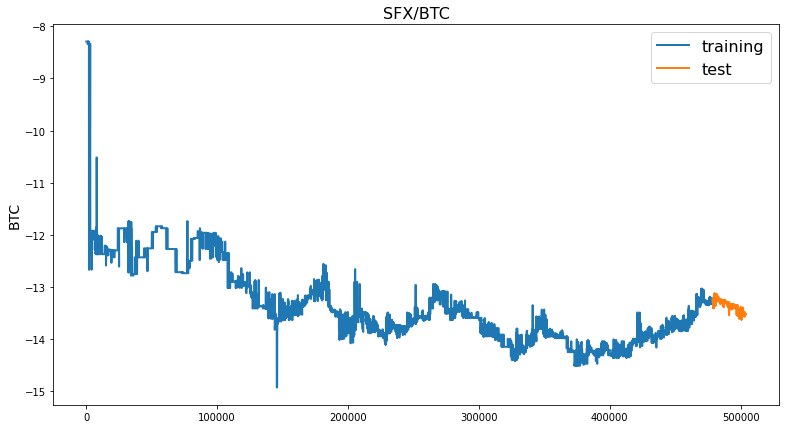

In [80]:
hist = df
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.05)

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('BTC', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

line_plot(np.log(train['close']), np.log(test['close']), 'training', 'test', title='SFX/BTC')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test